#### Data loading and preprocessing 

In [1]:
import numpy as np

In [2]:
with np.load('cifar4-train.npz',allow_pickle=False) as npz_file:
    data = dict(npz_file.items())
    print (data.keys())

dict_keys(['pixels', 'overfeat', 'labels', 'names', 'allow_pickle'])


In [13]:
# Convert pixels into floating point numbers
X = data['pixels'].astype(np.float32)

# Rescale pixel values between -0.5 and 0.5
X = (X - 128) / 255

#reshape to 32,32,3
X = X.reshape(-1,32,32,3)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
    
# Create train set
X_train, X_test, y_train, y_test = train_test_split(X,data['labels'],test_size=1800, random_state=0)

# Create validation and test sets
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=1000, random_state=0)

print('Train:', X_train.shape, y_train.shape)
print('Valid:', X_valid.shape, y_valid.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (3200, 32, 32, 3) (3200,)
Valid: (800, 32, 32, 3) (800,)
Test: (1000, 32, 32, 3) (1000,)


In [8]:
# Batch generator
def get_batches(X, y, batch_size):
    # Shuffle X,y
    shuffled_idx = np.arange(len(y)) # 1,2,...,n
    np.random.shuffle(shuffled_idx)
    
    # Enumerate indexes by steps of batch_size
    # i: 0, b, 2b, 3b, 4b, .. where b is the batch size
    for i in range(0, len(y), batch_size):
        # Batch indexes
        batch_idx = shuffled_idx[i:i+batch_size]
        yield X[batch_idx], y[batch_idx]

#### Building graph, convolutional layer

In [15]:
import tensorflow as tf

# Create new graph
graph = tf.Graph()

with graph.as_default():
    # Placeholders
    X = tf.placeholder(dtype=tf.float32, shape=[None, 32, 32, 3])
    y = tf.placeholder(dtype=tf.int32, shape=[None])
    print ('input:',X.shape)
    
     # Convolutional layer (64 filters, 5x5 kernels, stride: 2)
    conv1 = tf.layers.conv2d(X, 64, (5, 5), (2, 2), 'SAME',activation=tf.nn.relu,
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),name='conv1')
    print('Convolutional layer:', conv1.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool1 = tf.layers.max_pooling2d(conv1, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool1.shape)
    
    # Convolutional layer (64 filters, 3x3, stride: 1)
    conv2 = tf.layers.conv2d(pool1, 64, (3, 3), (1, 1), 'SAME',activation=tf.nn.relu,
                             kernel_initializer=tf.truncated_normal_initializer(stddev=0.01, seed=0),name='conv2')
    print('Convolutional layer:', conv2.shape)
    
    # Maxpool layer (2x2, stride: 2, "same" padding)
    pool2 = tf.layers.max_pooling2d(conv2, (2, 2), (2, 2), 'SAME')
    print('Maxpool:', pool2.shape)
    
    # Flatten output
    flat_output = tf.contrib.layers.flatten(pool2)
    print('Flatten:', flat_output.shape)
    
    # Dropout
    training = tf.placeholder(dtype=tf.bool)
    flat_output = tf.layers.dropout(flat_output, rate=0.5, seed=0, training=training)
    print('Dropout:', flat_output.shape)
    
    # Fully connected layer
    fc1 = tf.layers.dense(flat_output, 256,activation=tf.nn.relu,
                          kernel_initializer=tf.variance_scaling_initializer(scale=2, seed=0),
                          bias_initializer=tf.zeros_initializer())
    print('Fully-connected layer:', fc1.shape)
    
    # Output layer
    logits = tf.layers.dense(fc1,4,activation=None,kernel_initializer=tf.variance_scaling_initializer(scale=1, seed=0)
                             ,bias_initializer=tf.zeros_initializer())
    print('Output layer:', logits.shape)
    
    # Kernel of the 1st conv. layer
    with tf.variable_scope('conv1', reuse=True):
        conv_kernels = tf.get_variable('kernel')
    
    # Mean cross-entropy
    mean_ce = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits))
    
    # Adam optimizer
    lr = tf.placeholder(dtype=tf.float32)
    gd = tf.train.AdamOptimizer(learning_rate=lr)

    # Minimize cross-entropy
    train_op = gd.minimize(mean_ce)
    
    # Compute predictions and accuracy
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    is_correct = tf.equal(y, predictions)
    accuracy = tf.reduce_mean(tf.cast(is_correct, dtype=tf.float32))

input: (?, 32, 32, 3)
Convolutional layer: (?, 16, 16, 64)
Maxpool: (?, 8, 8, 64)
Convolutional layer: (?, 8, 8, 64)
Maxpool: (?, 4, 4, 64)
Flatten: (?, 1024)
Dropout: (?, 1024)
Fully-connected layer: (?, 256)
Output layer: (?, 4)


In [23]:
# Validation accuracy
valid_acc_values = []

with tf.Session(graph=graph) as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    # Set seed
    np.random.seed(0)
    
    # Train several epochs
    for epoch in range(20):
        # Accuracy values (train) after each batch
        batch_acc = []
        
        for X_batch, y_batch in get_batches(X_train, y_train, 240):
            # Run training and evaluate accuracy
            _, acc_value = sess.run([train_op, accuracy], feed_dict={X: X_batch,y: y_batch,lr: 0.001,training: True})
            
            # Save accuracy (current batch)
            batch_acc.append(acc_value)

        # Evaluate validation accuracy
        valid_acc = sess.run(accuracy, feed_dict={X: X_valid,y: y_valid,training: False})
        valid_acc_values.append(valid_acc)
        
        # Print progress
        print('Epoch {} - valid: {:.3f} train: {:.3f} (mean)'.format(epoch+1, valid_acc, np.mean(batch_acc)))
        
    # Get 1st conv. layer kernels
    kernels = conv_kernels.eval()
    
    # Evaluate test accuracy
    test_acc = sess.run(accuracy, feed_dict={X: X_test,y: y_test,training: False})
    print('Convolutional network accuracy: {:.3f}'.format(test_acc))

Epoch 1 - valid: 0.472 train: 0.384 (mean)
Epoch 2 - valid: 0.517 train: 0.487 (mean)
Epoch 3 - valid: 0.535 train: 0.527 (mean)
Epoch 4 - valid: 0.565 train: 0.548 (mean)
Epoch 5 - valid: 0.587 train: 0.567 (mean)
Epoch 6 - valid: 0.600 train: 0.575 (mean)
Epoch 7 - valid: 0.619 train: 0.600 (mean)
Epoch 8 - valid: 0.625 train: 0.624 (mean)
Epoch 9 - valid: 0.654 train: 0.643 (mean)
Epoch 10 - valid: 0.665 train: 0.642 (mean)
Epoch 11 - valid: 0.655 train: 0.650 (mean)
Epoch 12 - valid: 0.674 train: 0.680 (mean)
Epoch 13 - valid: 0.668 train: 0.698 (mean)
Epoch 14 - valid: 0.685 train: 0.697 (mean)
Epoch 15 - valid: 0.706 train: 0.720 (mean)
Epoch 16 - valid: 0.729 train: 0.723 (mean)
Epoch 17 - valid: 0.721 train: 0.732 (mean)
Epoch 18 - valid: 0.721 train: 0.749 (mean)
Epoch 19 - valid: 0.714 train: 0.757 (mean)
Epoch 20 - valid: 0.725 train: 0.755 (mean)
Convolutional network accuracy: 0.710


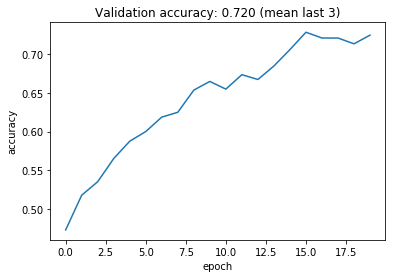

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt

# Plot accuracy values
plt.plot(valid_acc_values)
plt.title('Validation accuracy: {:.3f} (mean last 3)'.format(np.mean(valid_acc_values[-3:])))
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

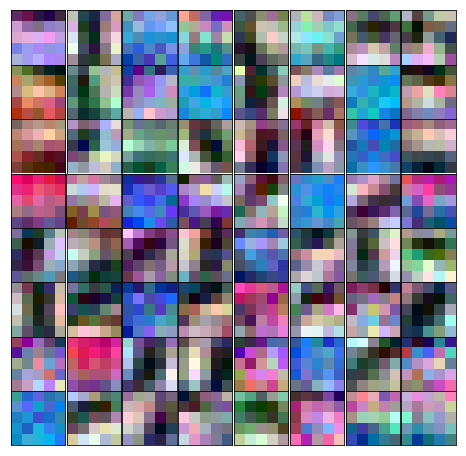

In [25]:
# Create a grid of subplots
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))

# Remove gaps between suplots
plt.subplots_adjust(wspace=0, hspace=0)

# Plot the 64 kernels from the first convolutional layer
for i, axis in enumerate(axes.flatten()):
    # Get i-th kernel (shape: 5x5x3)
    kernel = kernels[:, :, :, i].copy()
    
    # Rescale values between 0 and 1
    kernel -= kernel.min() # Rescale between 0 and max
    kernel /= kernel.max() # Rescale between 0 and 1
    
    # Plot kernel with imshow()
    axis.imshow(kernel)
    axis.get_xaxis().set_visible(False) # disable x-axis
    axis.get_yaxis().set_visible(False) # disable y-axis
    
plt.show()